<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/tutorials_notebooks_in_class_2024/03_tutorial_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML4NLP - Tutorial 3: Model Interpretability with SHAP

In order to understand a model's predictions -- and the errors it makes -- it can be useful to inspect the model's features given its predictions.

SHAP is just one of many model interpretability tools and uses ideas from Game Theory to estimate the importance of each feature for a particular prediction.

By interpreting a model trained on a set of features as a value function on a coalition of players, Shapley values provide a natural way to compute which features contribute to a prediction or contribute to the uncertainty of a prediction. If you're interested in the theory, you can read more [here](https://en.wikipedia.org/wiki/Shapley_value#In_machine_learning), or for some practical examples, see the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).


In this tutorial, we will go through a practical example of analysing a model's features using the 20news dataset.

In [ ]:
!pip install shap -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Initialize SHAP JavaScript visualization
shap.initjs()

---

## 1. Data Preparation

In [ ]:
# Define categories for the 20 Newsgroups dataset
categories = [
    'alt.atheism',
    'soc.religion.christian',
    'comp.graphics',
    'sci.med'
]

# Load the 20 Newsgroups dataset
twenty_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=SEED
)

twenty_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=SEED
)

# Prepare the data
X_train, y_train = twenty_train.data, twenty_train.target
X_test, y_test = twenty_test.data, twenty_test.target

# Print the number of training and test samples
print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))
print("Number of classes:", len(categories))

Number of training samples: 2257
Number of test samples: 1502
Number of classes: 4


---

## 2. Model Fitting

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.corpus import stopwords
import re
import string

# Download NLTK stopwords
nltk.download('stopwords')

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # Convert to lowercase
        text = text.lower()

        # Remove stopwords
        text = ' '.join([word for word in text.split() if word not in self.stop_words or word in string.punctuation])

        # Strip away new lines
        text = re.sub(r'\n', ' ', text)

        return text

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(min_df=10)),
    ('clf', LinearSVC(C=0.1, random_state=SEED)),
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred, target_names=categories))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                        precision    recall  f1-score   support

           alt.atheism       0.91      0.75      0.82       319
soc.religion.christian       0.87      0.98      0.92       389
         comp.graphics       0.94      0.88      0.91       396
               sci.med       0.86      0.94      0.90       398

              accuracy                           0.89      1502
             macro avg       0.90      0.89      0.89      1502
          weighted avg       0.90      0.89      0.89      1502



---

## 3. SHAP

Let's have a look at the importance attributed to the model's features using SHAP.

In [ ]:
# Get the feature names from the TfidfVectorizer
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()

# Create a function that applies the pipeline transformations
def pipeline_transform(X):
    return pipeline[:-1].transform(X).toarray()

# pipeline_transform(X_train)

# Initialize SHAP explainer
explainer = shap.Explainer(pipeline[-1], pipeline_transform(X_train), feature_names=feature_names)

In [ ]:
# Calculate SHAP values for the test set
shap_values = explainer(pipeline_transform(X_test))

print(shap_values.shape)

(1502, 4799, 4)


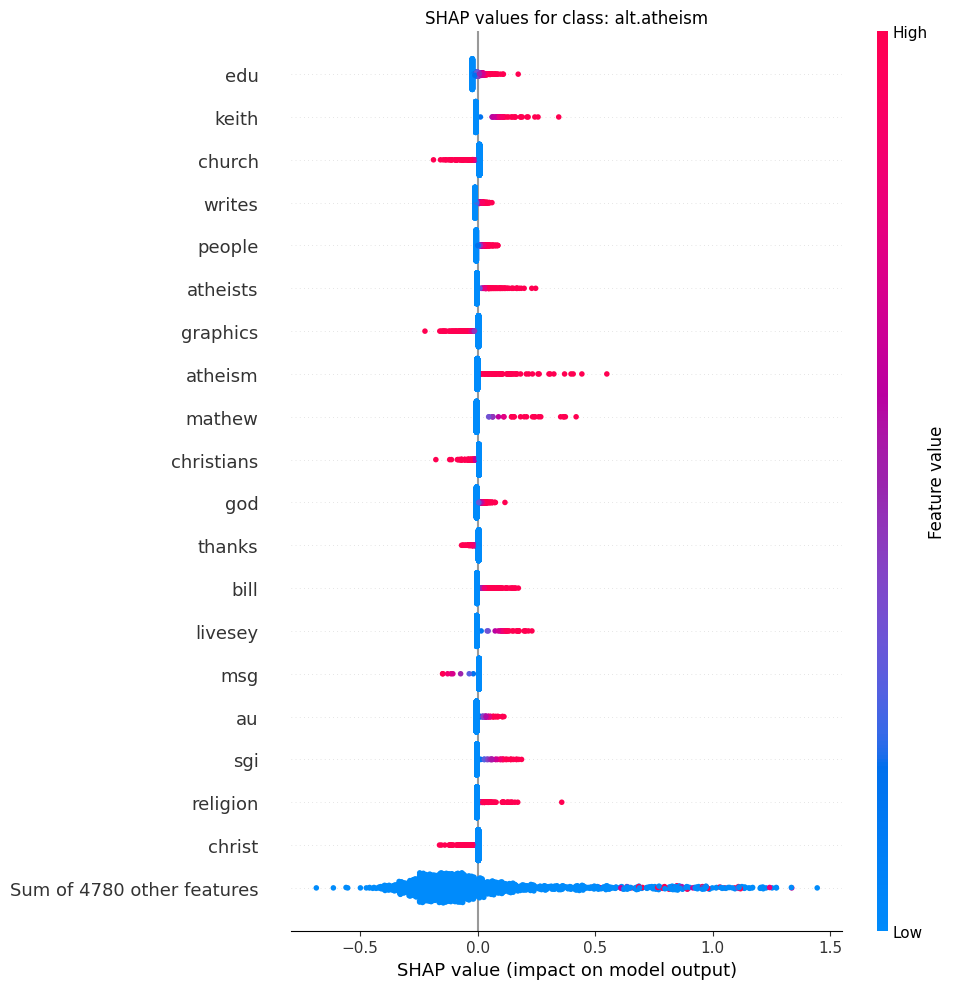

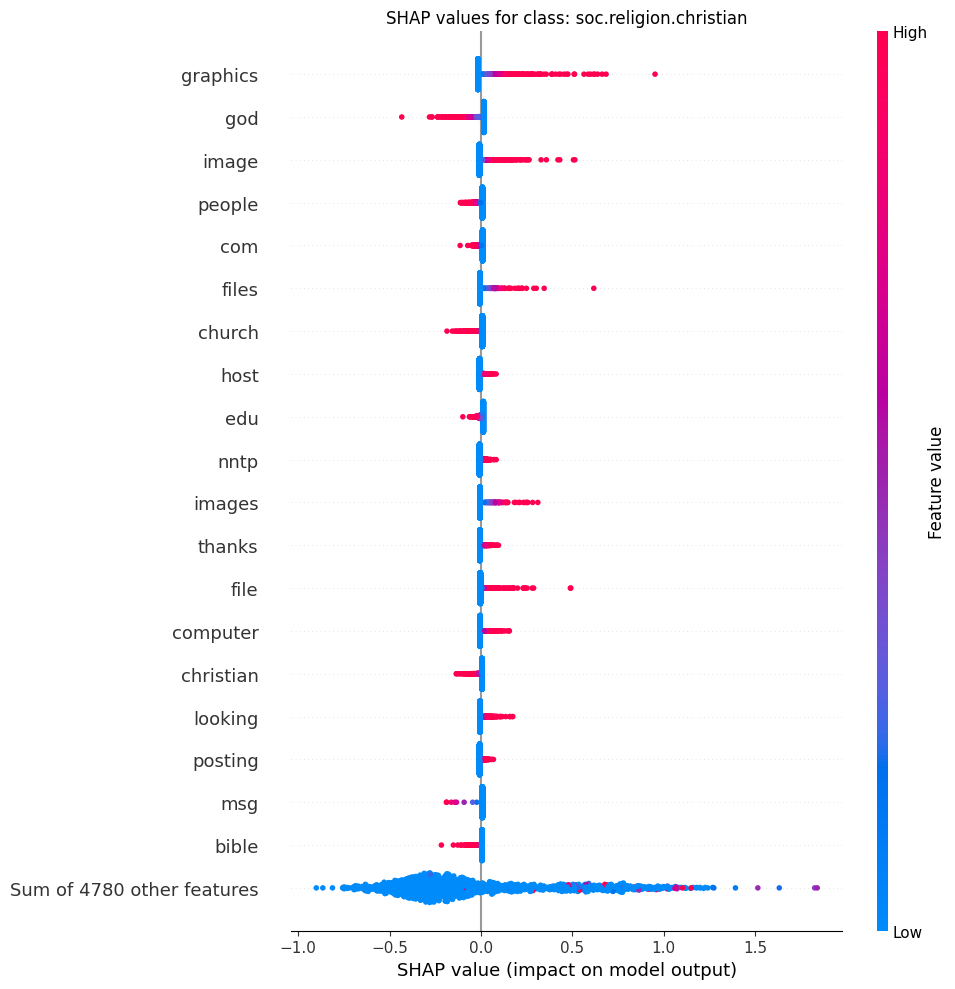

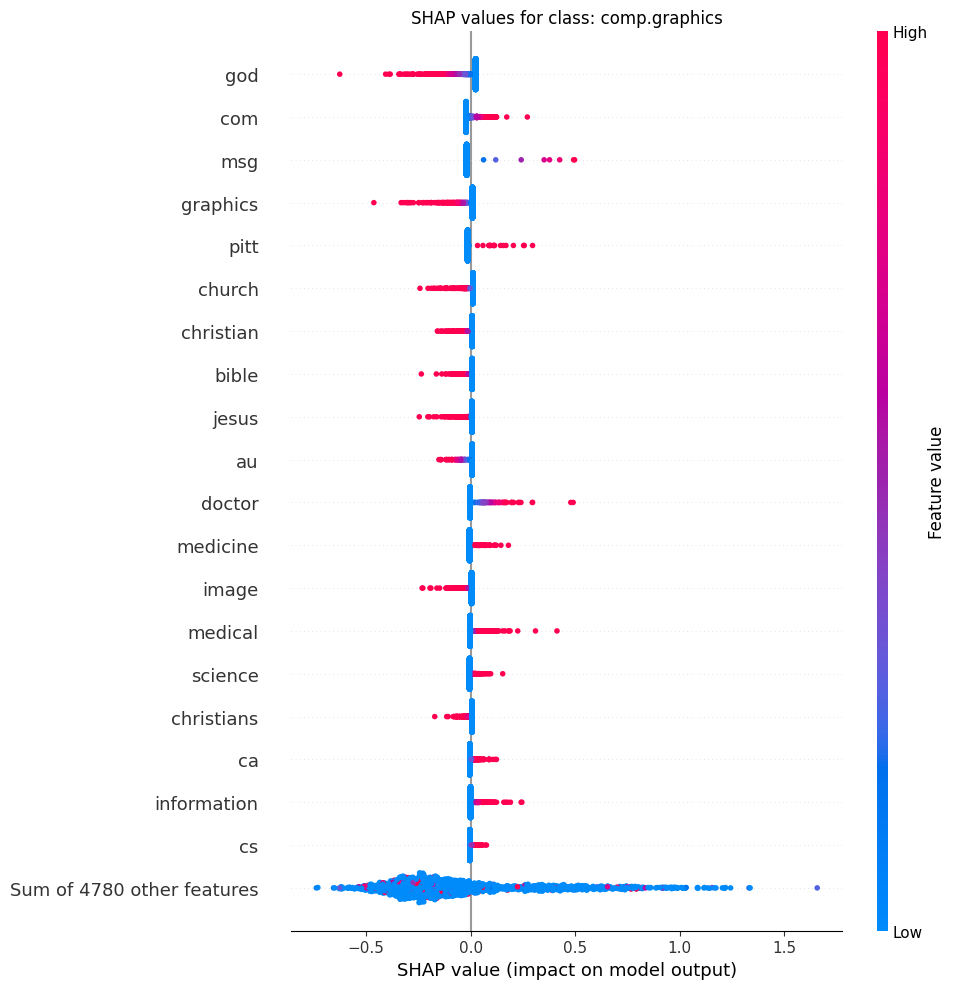

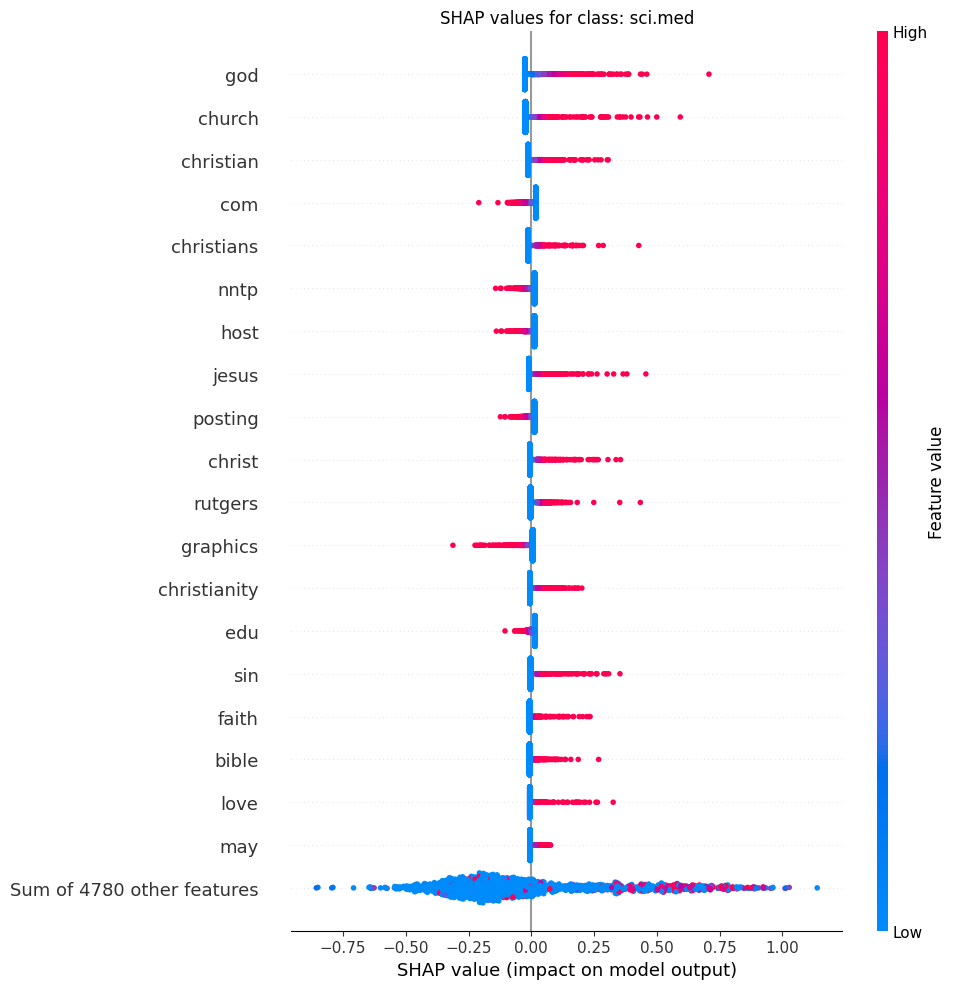

In [ ]:
# Create a single figure with beeswarm plots for all categories
for i, category in enumerate(categories):
    # Beeswarm plot
    figsize = (10, 10)
    plt.figure(figsize=figsize)
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20, show=False, plot_size=figsize)
    plt.title(f"SHAP values for class: {category}")
    plt.tight_layout()
    plt.show()

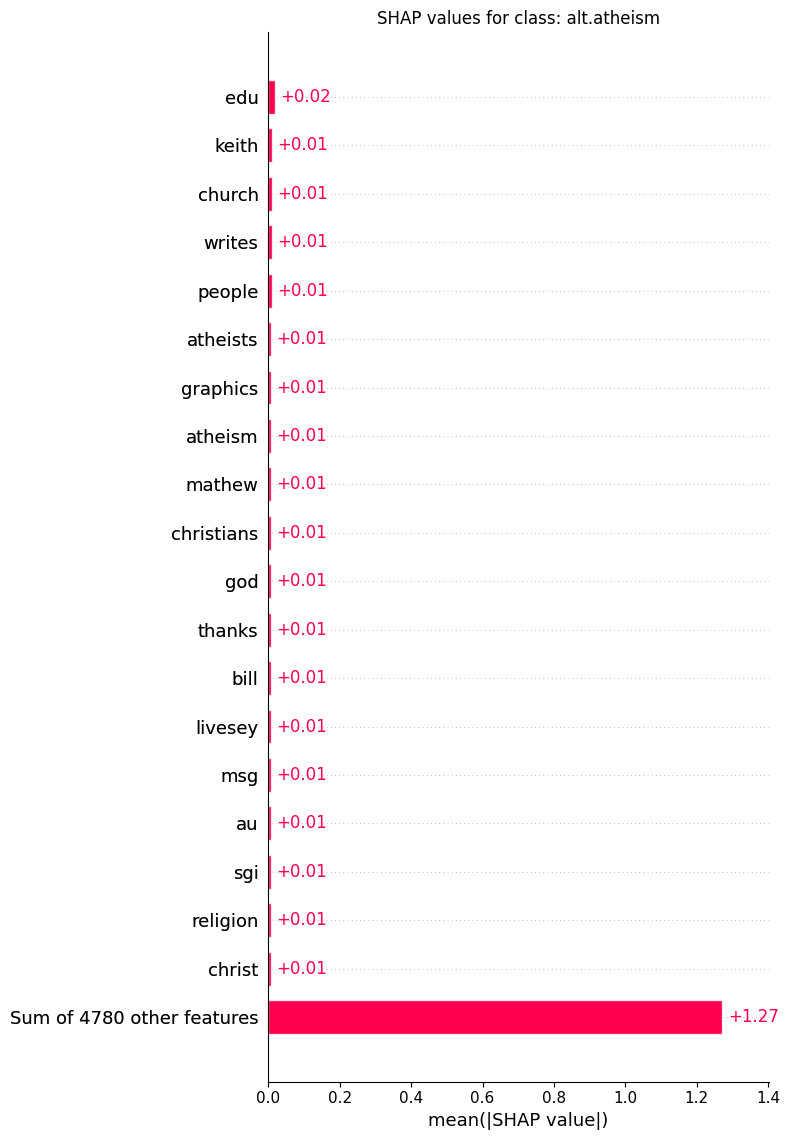

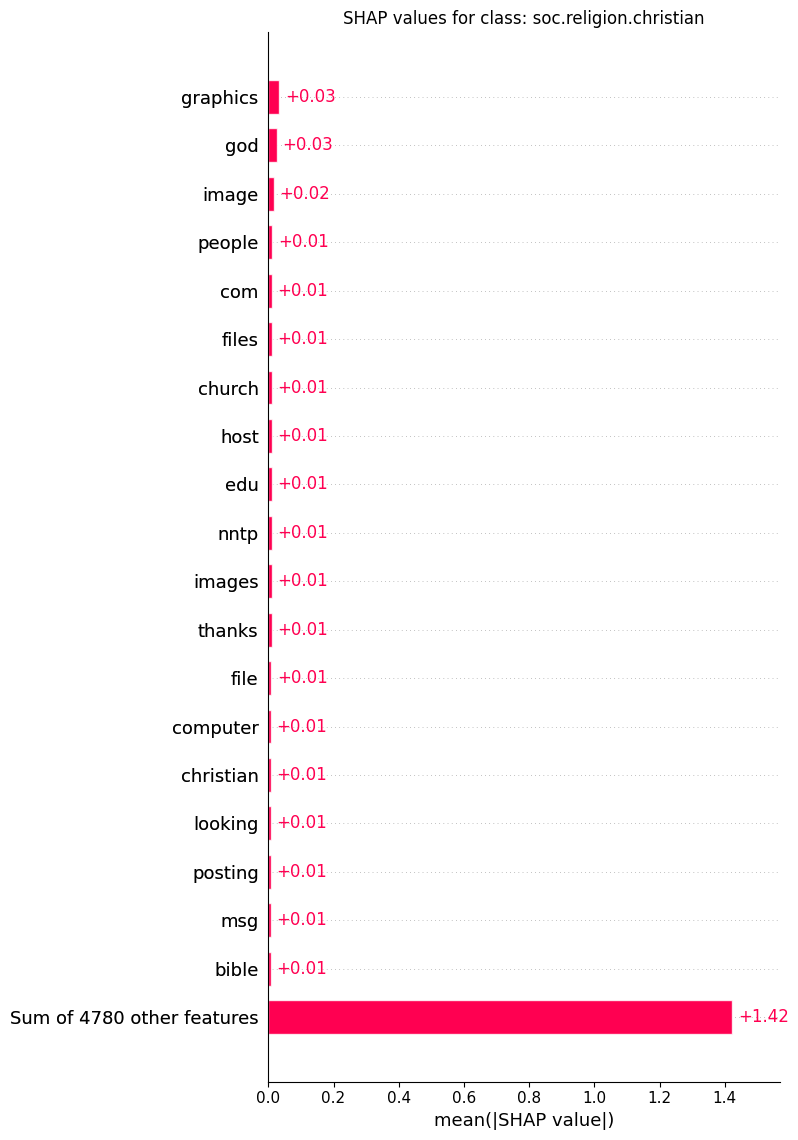

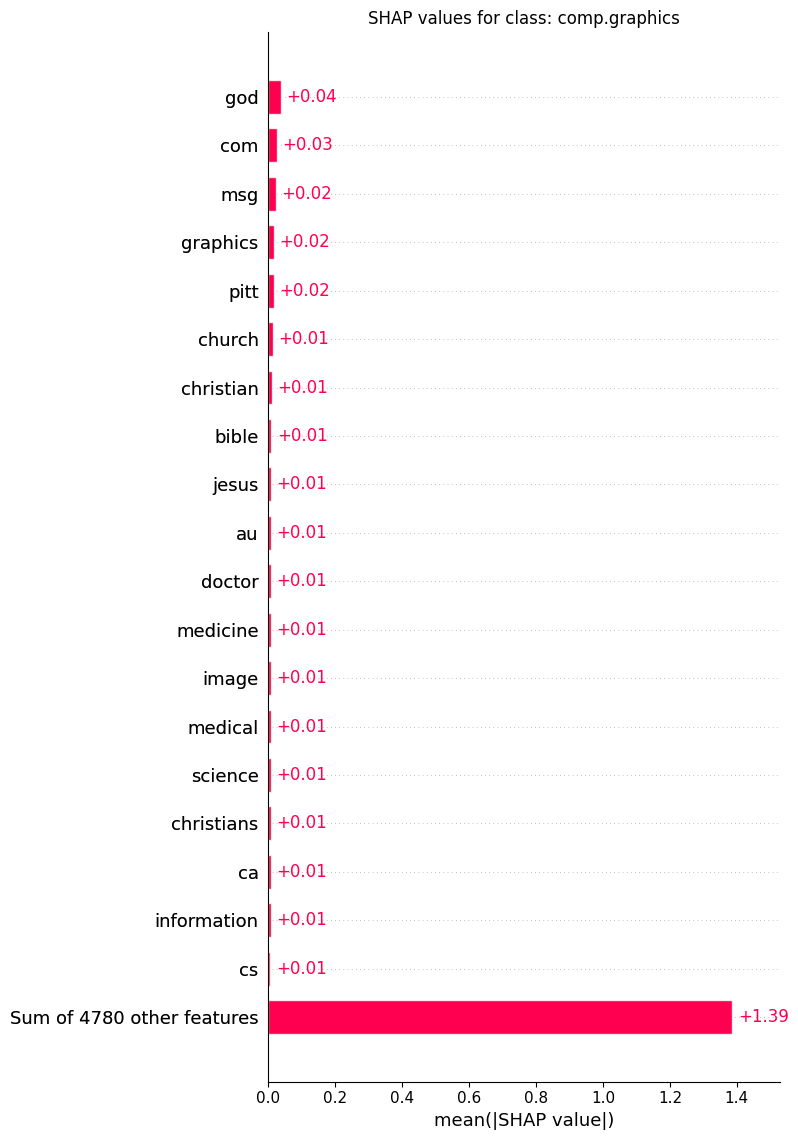

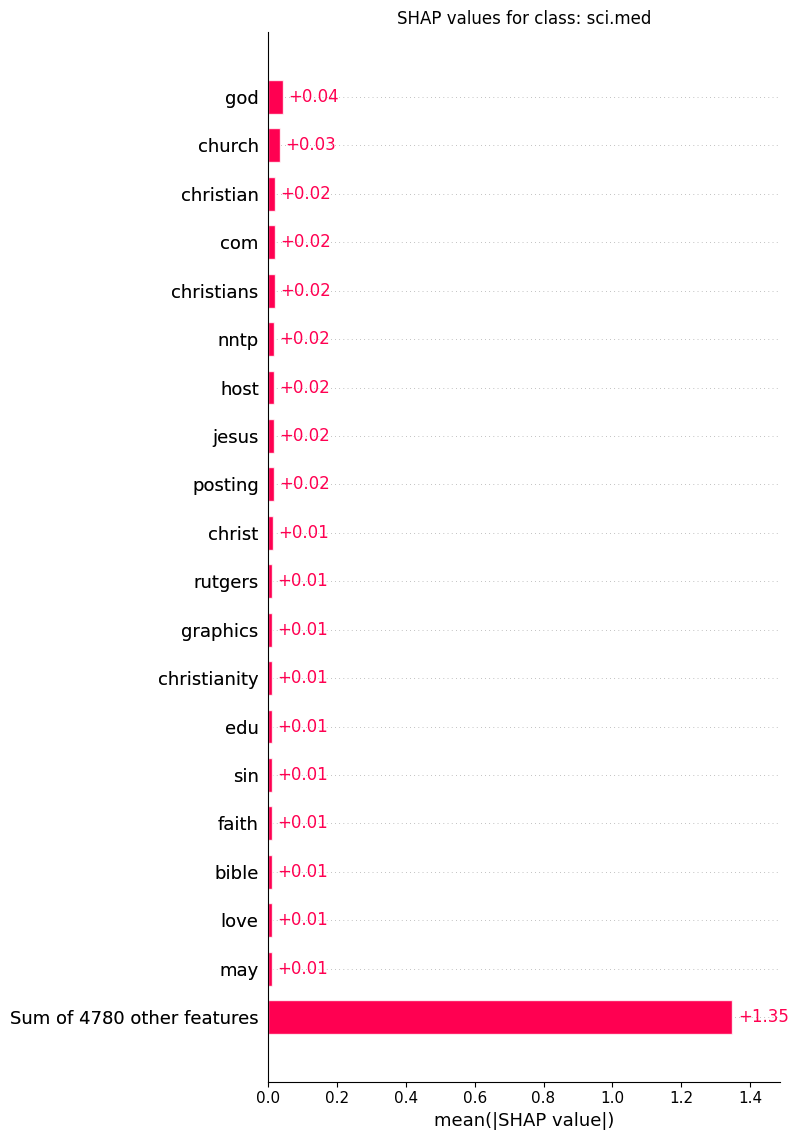

In [ ]:
# Create a single figure with Bar plots for all categories
for i, category in enumerate(categories):
    # Bar plot
    figsize = (10, 10)
    plt.figure(figsize=figsize)
    shap.plots.bar(shap_values[:, :, i], max_display=20, show=False)
    plt.title(f"SHAP values for class: {category}")
    plt.tight_layout()
    plt.show()

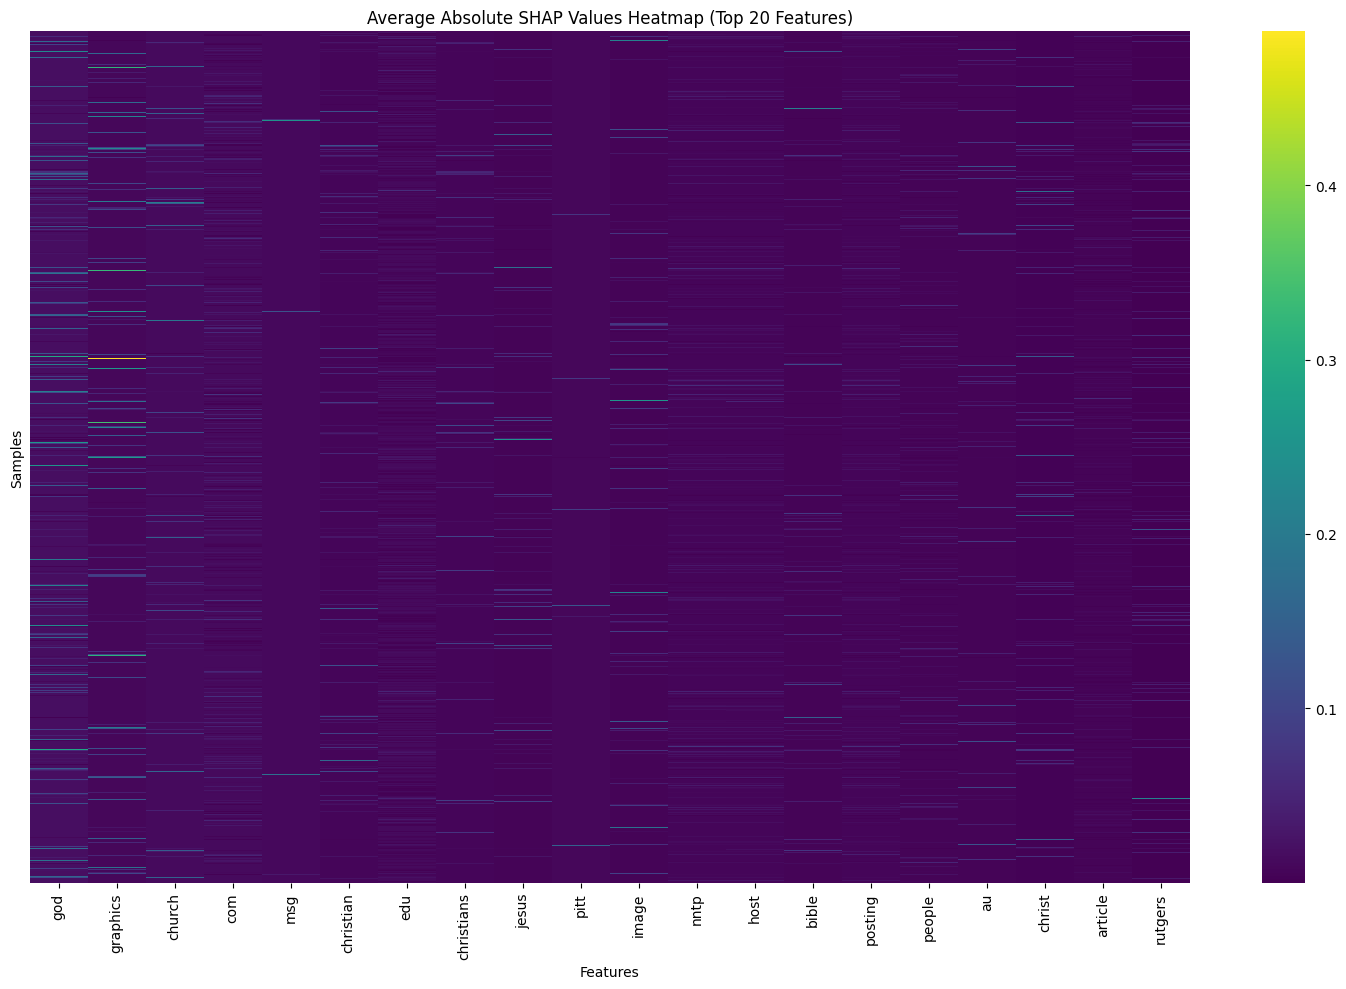

In [ ]:
# Create a custom heatmap of average absolute SHAP values across all classes
avg_shap_values = np.abs(shap_values.values).mean(axis=2)
top_features = avg_shap_values.mean(axis=0).argsort()[-20:][::-1]  # Top 20 features

plt.figure(figsize=(15, 10))
sns.heatmap(avg_shap_values[:, top_features],
            xticklabels=[feature_names[i] for i in top_features],
            yticklabels=False,
            cmap='viridis')
plt.title("Average Absolute SHAP Values Heatmap (Top 20 Features)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()

---



**Note**: There are different explainers available for SHAP. More details [here](https://shap.readthedocs.io/en/latest/api.html#explainers). You can also use a different explainer in the assignment like [eli5](https://eli5.readthedocs.io/en/latest/index.html)